## Week 5 Video Notebook -- Feature Selection and Regularization

In [1]:
# Useful imports

import numpy as np
from numpy import arange,linspace,mean, var, std
import matplotlib.pyplot as plt 
import matplotlib.patches as patches
import kagglehub

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SequentialFeatureSelector,f_regression,SelectKBest
from sklearn.datasets import make_regression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from itertools import chain, combinations

import math
import pandas as pd
import matplotlib.pyplot as plt
import time
import seaborn as sns

random_state = 42

### Download and prepare the dataset

In [2]:
# Download Kaggle Diabetes Dataset

from sklearn.datasets import load_diabetes
import pandas as pd

data_diabetes = load_diabetes(as_frame=True)
df_diabetes = pd.concat([data_diabetes.data, data_diabetes.target.rename('DiseaseProgression')], axis=1)

feature_names = df_diabetes.drop(columns=["DiseaseProgression"]).columns.tolist()

df_diabetes.head()


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6,DiseaseProgression
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019907,-0.017646,151.0
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068332,-0.092204,75.0
2,0.085299,0.050680,0.044451,-0.005670,-0.045599,-0.034194,-0.032356,-0.002592,0.002861,-0.025930,141.0
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022688,-0.009362,206.0
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031988,-0.046641,135.0


In [3]:
df_diabetes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   age                 442 non-null    float64
 1   sex                 442 non-null    float64
 2   bmi                 442 non-null    float64
 3   bp                  442 non-null    float64
 4   s1                  442 non-null    float64
 5   s2                  442 non-null    float64
 6   s3                  442 non-null    float64
 7   s4                  442 non-null    float64
 8   s5                  442 non-null    float64
 9   s6                  442 non-null    float64
 10  DiseaseProgression  442 non-null    float64
dtypes: float64(11)
memory usage: 38.1 KB


#### Features of the Diabetes Dataset

- **age**: age of the patient  
- **sex**: gender of the patient  
- **bmi**: body mass index (BMI)  
- **bp**:  mean blood pressure  
- **s1**:  measure of serum cholesterol levels  
- **s2**:  measure related to low-density lipoproteins (LDL)  
- **s3**:  measure of high-density lipoproteins (HDL)  
- **s4**:  measure of total cholesterol-to-HDL ratio  
- **s5**:  measure of serum triglycerides  
- **s6**:  measure of blood sugar levels  
- **DiseaseProgression**: Quantitative measure of diabetes disease progression one year after baseline (target variable)  



Let's rename the feature 'sex' to the more typical term 'gender'. 

In [4]:
df_diabetes.rename(columns={'sex': 'gender'}, inplace=True)

In [5]:
# Create dataset suitable for analysis and split it for later use

# In order to preserve feature names to show data graphics, we will keep all the data as dataframes

X = df_diabetes.drop(columns="DiseaseProgression")
y = df_diabetes["DiseaseProgression"]

test_size = 0.1      # with very small datasets, this might work better. 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state=random_state)

len(X),len(y),len(X_train), len(y_train),len(X_test),len(y_test)

(442, 442, 397, 397, 45, 45)

### Linear Regression on the Diabetes Dataset

In order to establish a baseline, we first perform ordinary Linear Regression on the dataset. 


In [6]:
def run_linear_regression(X_train,y_train,X_test,y_test,
                          cv=5,
                          scoring='neg_mean_squared_error',
                          n_jobs = -1
                          ):
   
    # Define the model
    model = LinearRegression()

    # Compute cross-validated MSE
    cv_score = -cross_val_score(model,X_train,y_train,
                                cv=5,
                                scoring='neg_mean_squared_error',
                                n_jobs = n_jobs,
                               ).mean()

    # Fit the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred_test = model.predict(X_test)

    # Compute the test MSE
    test_mse = mean_squared_error(y_test, y_pred_test)
    
    return cv_score,test_mse,model

In [7]:
cv_score, test_mse, baseline_model = run_linear_regression(X_train, y_train, 
                                                           X_test, y_test,
                                                           cv=5, 
                                                           scoring='neg_mean_squared_error'
                                                          )

# Print the results
print("Baseline Linear Regression:\n")
print(f"CV Score: {cv_score:.4f}")
print(f"Test MSE: {test_mse:.4f}\n")

# Extract coefficients
coefficients = baseline_model.coef_  # Coefficients for each feature
intercept = baseline_model.intercept_  # Intercept term


# Automatically extract feature names from X_train
feature_names = X_train.columns.tolist()

coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": np.around(coefficients,4)
})

print(f"\nIntercept: {intercept:.4f}\n")

print(coefficients_df.to_string(index=False))


Baseline Linear Regression:

CV Score: 3047.7321
Test MSE: 2743.9112


Intercept: 151.7226

Feature  Coefficient
    age      19.9273
 gender    -262.5526
    bmi     509.1958
     bp     336.0932
     s1    -849.3048
     s2     480.2266
     s3     120.6906
     s4     236.7223
     s5     716.6128
     s6      70.4100


## Feature Selection

We will consider three methods for improving our model using feature selection:

- Exhaustive search through every possible combination of features
- Forward selection
- Backward selection


### Exhaustive Search

Given the small size of the dataset with only 10 features, we can afford to evaluate every possible non-empty subset of features. This exhaustive approach guarantees the best possible CV score achievable through feature selection, serving as a lower bound for comparison. 

In [8]:
# Find best subset of features by trying every non-empty subset

# Function to generate all non-empty subsets of a set
def all_subsets(features):
    return chain.from_iterable(combinations(features, r) for r in range(1, len(features) + 1))


# Model to use for evaluation
model = LinearRegression()

# Dictionary to store subset results
subset_scores = []

# Iterate over all non-empty subsets of the features
for subset in all_subsets(X.columns):
    subset = list(subset)  # Convert tuple to list
    cv_score = -cross_val_score(model, X[subset], y, scoring='neg_mean_squared_error', cv=5).mean()
    subset_scores.append((subset, np.around(cv_score,4)))

# Convert results to a DataFrame for sorting
subset_scores = pd.DataFrame(subset_scores, columns=["Features", "CV Score (MSE)"])
subset_scores = subset_scores.sort_values(by="CV Score (MSE)").reset_index(drop=True)

# Print the top 10 subsets
print(subset_scores.head(5))


                                Features  CV Score (MSE)
0      [gender, bmi, bp, s1, s2, s4, s5]       2944.8991
1          [gender, bmi, bp, s1, s2, s5]       2946.8869
2  [gender, bmi, bp, s1, s2, s3, s4, s5]       2947.8309
3          [gender, bmi, bp, s1, s4, s5]       2950.0372
4      [gender, bmi, bp, s1, s2, s3, s5]       2950.5542


### Testing the result of the exhaustive method

In [9]:
# Test exhaustive solution

# Assuming subset_scores is a DataFrame with the features and CV scores

# Extract the features from the first row

best_subset = subset_scores.iloc[0]["Features"]
best_cv_score = subset_scores.iloc[0]["CV Score (MSE)"]

# Filter X_train and X_test to include only the selected features
X_train_best = X_train[best_subset]
X_test_best = X_test[best_subset]

# Train the LinearRegression model on the selected features
model = LinearRegression()
model.fit(X_train_best, y_train)

# Predict on the test set
y_pred = model.predict(X_test_best)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)

# Print the results
print(f"Optimal Features: {best_subset}")
print(f"CV Score (MSE):   {best_cv_score:.4f}")
print(f"Test MSE:         {test_mse:.4f}")


Optimal Features: ['gender', 'bmi', 'bp', 's1', 's2', 's4', 's5']
CV Score (MSE):   2944.8991
Test MSE:         2703.7499


### Forward Selection

Let's proceed to apply the forward selection algorithm and see what happens!

In [10]:
# Forward Feature Selection

def forward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,               # None = no delta cutoff
                                                              # use 0.0 for "no further improvements"
                                                              # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,      # None = use all features
                                      n_jobs = -1,
                                      verbose = True
                                     ):
    selected_features = []
    remaining_features = list(X.columns)
    best_scores = []
    previous_score = float('inf')
    
    # Model to use for evaluation
    model = LinearRegression()

    # Track the best subset and its score
    best_forward_features = None
    best_score = float('inf')
    
    while remaining_features:
        scores = {}
        for feature in remaining_features:
            current_features = selected_features + [feature]
            # Compute the CV score
            cv_score = -cross_val_score(model, X[current_features], y, 
                                        scoring=scoring, cv=cv,n_jobs=n_jobs,
                                       ).mean()
            scores[feature] = cv_score

        # Select the feature that minimizes the CV score
        best_feature = min(scores, key=scores.get)
        current_score = scores[best_feature]

        # Check if the improvement is significant
        if verbose and tol is not None and previous_score - current_score < tol:
            print("Stopping early due to minimal improvement.")
            break

        # Add the best feature to the selected list
        selected_features.append(best_feature)
        best_scores.append(current_score)
        remaining_features.remove(best_feature)
        previous_score = current_score

        if verbose:
            print(f"Features: {selected_features}, CV Score (MSE): {current_score:.4f}")
        
        # Update the best subset if the current score is the best so far
        if current_score < best_score:
            best_score = current_score
            best_forward_features = selected_features.copy()
        
        # Check if max_features has been reached
        if max_features is not None and len(selected_features) >= max_features:
            break

    return selected_features, best_scores, best_forward_features, best_score

Features: ['bmi'], CV Score (MSE): 3903.0513
Features: ['bmi', 's5'], CV Score (MSE): 3220.1663
Features: ['bmi', 's5', 'bp'], CV Score (MSE): 3110.2068
Features: ['bmi', 's5', 'bp', 's3'], CV Score (MSE): 3049.9696
Features: ['bmi', 's5', 'bp', 's3', 'gender'], CV Score (MSE): 2966.1770
Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1'], CV Score (MSE): 2954.7364
Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1', 's2'], CV Score (MSE): 2950.5542
Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1', 's2', 's4'], CV Score (MSE): 2947.8309
Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1', 's2', 's4', 'age'], CV Score (MSE): 2961.1029
Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1', 's2', 's4', 'age', 's6'], CV Score (MSE): 2993.0813


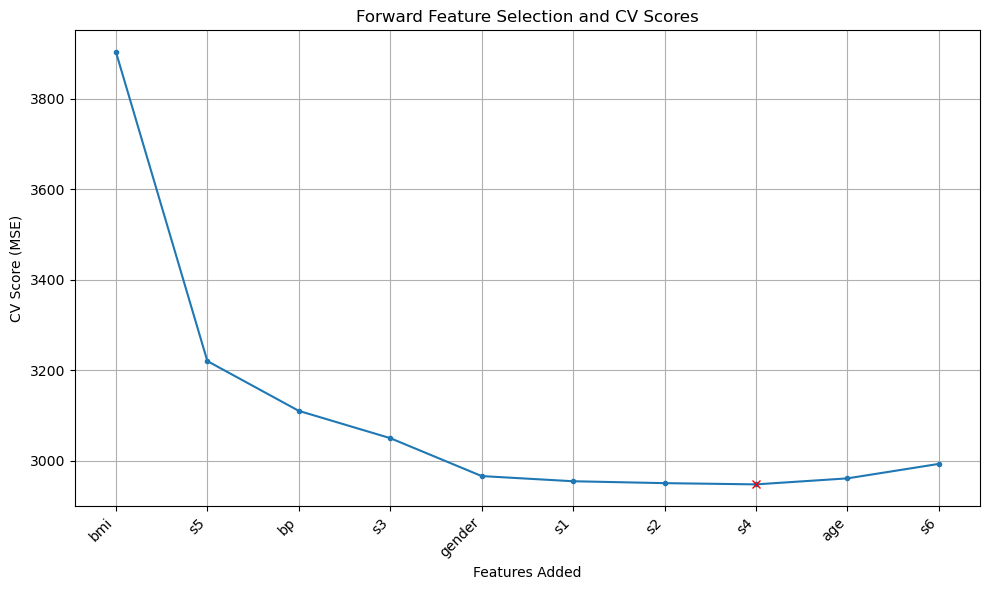

Best Features: ['bmi', 's5', 'bp', 's3', 'gender', 's1', 's2', 's4']
Best CV Score: 2947.8309
Test MSE: 2711.9788


In [11]:
# Run Forward Feature Selection

model = LinearRegression()

selected_features, best_scores, best_forward_features, best_score =    (
            forward_feature_selection(X, y, model, verbose=True) )

# Plot the results

index = np.argmax(np.array(selected_features) == best_forward_features[-1])

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_scores) + 1), best_scores, marker='.')
plt.plot([index+1],best_score,marker='x',color='red')
plt.xticks(range(1, len(selected_features) + 1), selected_features, rotation=45, ha='right')
plt.title('Forward Feature Selection and CV Scores')
plt.xlabel('Features Added')
plt.ylabel('CV Score (MSE)')
plt.grid()
plt.tight_layout()
plt.show()

# Print the best subset and score
print(f"Best Features: {best_forward_features}")
print(f"Best CV Score: {best_score:.4f}")

# Testing

# Filter X_train and X_test to include only the selected features
X_train_best = X_train[best_forward_features]
X_test_best = X_test[best_forward_features]

# Run the test set through the model
model = LinearRegression()
model.fit(X_train_best, y_train)

y_pred = model.predict(X_test_best)

test_mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {test_mse:.4f}")

### Your Turn!

Experiment with the `tol` and `max_features` parameters and observe their effect. 

### Backward Selection


In [12]:
# Backward selection algorithm

def backward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,               # None = no delta cutoff
                                                              # use 0.0 for "no further improvements"
                                                              # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,      # None = use all features
                                      n_jobs = -1,
                                      verbose=True
                                     ):
    
    def cv_score(features):
        return -cross_val_score(LinearRegression(), X[features], y, 
                                scoring=scoring, cv=cv, n_jobs=n_jobs).mean()

    features_remaining = np.array(X.columns)
    scores = [ (features_remaining,'None',cv_score(features_remaining))]   # (feature removed, cv score after removed)

    if verbose:
        print("Start with full set of features:")
        print(f'{features_remaining}  CV score (MSE): {scores[0][2]}\n')

    if max_features == None:
        max_features = len(X.columns)
     
    prev_score = float('inf')
    for i in range(1,max_features):
        if verbose:
            print(f'Round {i}:')
        # calculate cv score for every possible removal of a feature
        lowest_score = (None,None,float('inf'))

        for k in range(len(features_remaining)):
            new_feature_set = np.delete(features_remaining,k)    # np.delete makes a copy and then deletes
            new_score = cv_score(new_feature_set)
            if verbose:
                print(new_feature_set, features_remaining[k], np.around(new_score,4))
            if new_score < lowest_score[2]:
                lowest_score = (new_feature_set,features_remaining[k],new_score)
            
        # Check if improvement is below the tolerance
        if tol is not None and (prev_score - lowest_score[2]) < tol:
            print("\nStopping early due to minimal improvement.")
            break
            
        prev_score = lowest_score[2]
        
        features_remaining = lowest_score[0]
        scores.append(lowest_score)
        if verbose:
            print(f'\nRemoving {lowest_score[1]}:  CV score (MSE) {np.around(lowest_score[2]) }\n')
            
    return scores

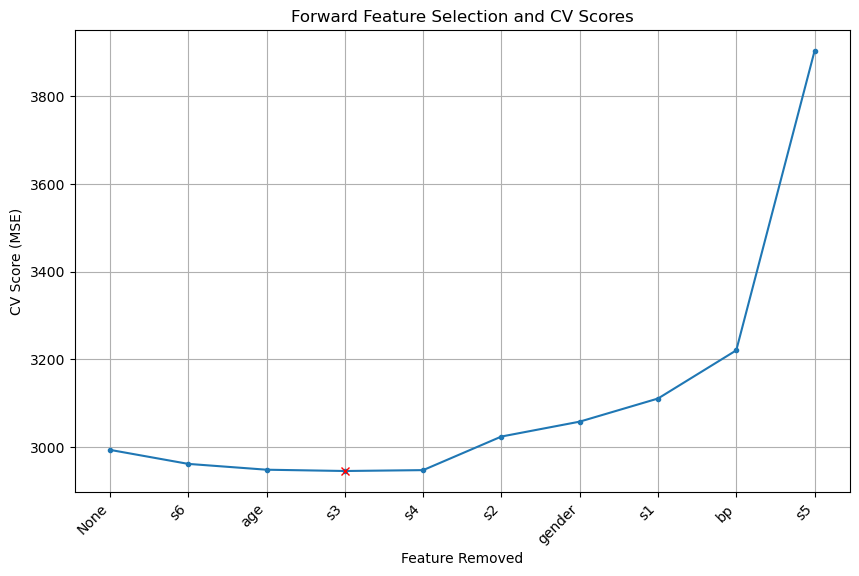

Best feature set: ['gender' 'bmi' 'bp' 's1' 's2' 's4' 's5']
CV score (MSE): 2944.8991
Test MSE: 2703.7499


In [13]:
# run backward selection and display results

scores = backward_feature_selection(X, y, model, 
                                      scoring='neg_mean_squared_error', 
                                      cv=5, 
                                      tol=None,             # None = no delta cutoff
                                                            # use 0.0 for "no further improvements"
                                                            # and 1e-4 for "point of diminishing returns"                                      
                                      max_features=None,    # None = use all features
                                      verbose=False
                                     )

x_axis, y_axis = np.array( [sc[1] for sc in scores] ), np.array( [sc[2] for sc in scores] ) 

(best_feature_set, feature_removed, best_score) = min(scores, key=lambda sc: sc[2])
index = np.argmax(np.array(x_axis) == feature_removed)

plt.figure(figsize=(10,6))
plt.title("Forward Feature Selection and CV Scores")
plt.plot(x_axis,y_axis,marker='.')
plt.plot([index],best_score,marker='x',color='red')
plt.xlabel('Feature Removed')
plt.ylabel('CV Score (MSE)')
plt.xticks(range(len(x_axis)),x_axis, rotation=45, ha='right')
plt.grid()
plt.show()


# Print minimum cv score

print("Best feature set:", best_feature_set)
print("CV score (MSE):",np.around(best_score,4))

# Test

# Filter X_train and X_test to include only the selected features
X_train_best_backward = X_train[best_feature_set]
X_test_best_backward = X_test[best_feature_set]

# Train the LinearRegression model on the selected features
model = LinearRegression()
model.fit(X_train_best_backward, y_train)

# Predict on the test set
y_pred = model.predict(X_test_best_backward)

# Calculate the test MSE
test_mse = mean_squared_error(y_test, y_pred)

print(f"Test MSE: {test_mse:.4f}")

### Your Turn!

Run the algorithm with `verbose=True` and verify its correctness by checking that the feature selected for removal at each step is the one that results in the smallest MSE.


## Regularization 

We will experiment with two different regularization techniques for regression:

- Ridge Regression using the L2 loss function
- Lasso Regression using the L1 loss function

(There is also a third, Elastic Nets, which uses a weighted combination of these two.)



### Ridge Regression

Regularization requires that the features be scaled or standardized to have a mean of 0.0 and standard deviation of 1.0. We will do this to all datasets uniformly when performing Ridge, Lasso, and Elastic Nets. 

In [14]:
# Ridge regression with scaling

def run_ridge_regression(X_train, y_train, X_test, y_test,
                         log_alphas=np.logspace(-6, -3, 100),  # Logarithmic range from 1e-6 to 1e-3
                         lin_alphas=np.linspace(0.0, 0.001, 100),
                         log_scale=False,
                         n_jobs = -1
                        ):

    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_test_scaled = scaler.transform(X_test)        # Transform the test data using the same scaler

    # Define the range of alpha values based on the log_scale flag
    alphas = log_alphas if log_scale else lin_alphas  

    cv_mse_scores = []  # List to store the CV MSE scores

    # Compute CV scores for each alpha
    for alpha in alphas:
        ridge = Ridge(alpha=alpha)  
        cv_score = -cross_val_score(ridge, X_train_scaled, y_train, 
                                    scoring='neg_mean_squared_error', cv=5,n_jobs=n_jobs).mean()
        cv_mse_scores.append(cv_score) 

    # Find the optimal alpha
    optimal_index = np.argmin(cv_mse_scores)
    optimal_alpha = alphas[optimal_index]
    optimal_cv_score = cv_mse_scores[optimal_index]

    # Train Ridge regression with the optimal alpha on the scaled training data
    optimal_model = Ridge(alpha=optimal_alpha)
    optimal_model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = optimal_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_pred)

    # Plot CV MSE against alpha
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, cv_mse_scores, label="CV MSE")
    plt.scatter([optimal_alpha], [optimal_cv_score], color='red', marker='x', label='Optimal Alpha', zorder=5)

    # Set scale dynamically based on the log_scale flag
    if log_scale:
        plt.xscale('log')  # Logarithmic scale for alpha
        plt.xlabel('Alpha (log scale)')
    else:
        plt.xlabel('Alpha (linear scale)')

    plt.ylabel('Cross-Validated Mean Squared Error (MSE)')
    plt.title('Effect of Alpha on Ridge Regression (CV MSE)')
    plt.legend()
    plt.grid()
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

    # Print the optimal alpha and its CV score
    print(f"Optimal alpha: {optimal_alpha:.4f}")
    print(f"Optimal CV score (MSE): {optimal_cv_score:.4f}")
    print(f"Test MSE: {test_mse:.4f}")
    
    # Extract coefficients
    coefficients = optimal_model.coef_  # Coefficients for each feature
    intercept = optimal_model.intercept_  # Intercept term


    # Automatically extract feature names from X_train
    feature_names = X_train.columns.tolist()

    coefficients_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": np.around(coefficients,4)
    })

    print(f"\nIntercept: {intercept:.4f}\n")

    print(coefficients_df.to_string(index=False))


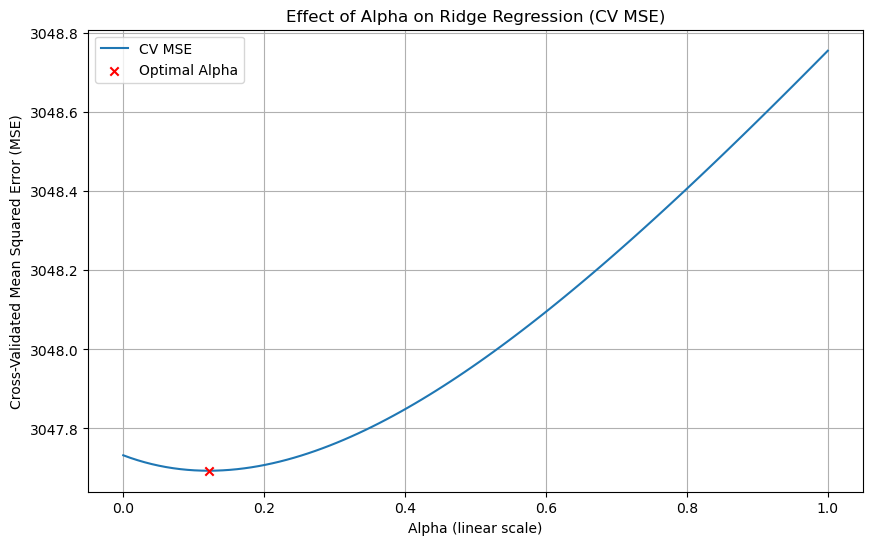

Optimal alpha: 0.1212
Optimal CV score (MSE): 3047.6931
Test MSE: 2743.1583

Intercept: 152.0101

Feature  Coefficient
    age       0.9330
 gender     -12.4498
    bmi      23.9105
     bp      16.1761
     s1     -38.8601
     s2      21.9251
     s3       5.2269
     s4      11.2804
     s5      33.7192
     s6       3.4011


In [36]:
run_ridge_regression(X_train,y_train,X_test,y_test,
                     log_alphas = np.logspace(-3, 0, 100),  # Logarithmic range from 1e-6 to 1e-3
                     lin_alphas = np.linspace(0, 1, 100),
                     log_scale=False                
                    )

### Lasso Regression

Again, play around with alpha, and try to improve on the baseline. Unfortunately, in Lasso, you can not set `alpha=0.0`. 

In [16]:
# Run Lasso Regression with scaling

def run_lasso_regression(X_train, y_train, X_test, y_test,
                         log_alphas=np.logspace(-6, -3, 100),  # Logarithmic range
                         lin_alphas=np.linspace(1e-6, 1, 100),  # Linear range
                         max_iter=10000,
                         log_scale=False,
                         n_jobs = -1
                        ):
    # Scale the data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Fit and transform the training data
    X_test_scaled = scaler.transform(X_test)        # Transform the test data using the same scaler

    # Define the range of alpha values based on the log_scale flag
    alphas = log_alphas if log_scale else lin_alphas  

    cv_mse_scores = []  # List to store the CV MSE scores

    # Compute CV scores for each alpha
    for alpha in alphas:
        lasso = Lasso(alpha=alpha, max_iter=max_iter)  # Create Lasso regression model
        # Cross-validate the model and compute the negative MSE
        cv_score = -cross_val_score(lasso, X_train_scaled, y_train, 
                                    scoring='neg_mean_squared_error', cv=5,n_jobs=n_jobs).mean()
        cv_mse_scores.append(cv_score)  # Store the mean CV MSE

    # Find the optimal alpha
    optimal_index = np.argmin(cv_mse_scores)
    optimal_alpha = alphas[optimal_index]
    optimal_cv_score = cv_mse_scores[optimal_index]

    # Train Lasso regression with the optimal alpha on the scaled training data
    optimal_model = Lasso(alpha=optimal_alpha, max_iter=max_iter)
    optimal_model.fit(X_train_scaled, y_train)

    # Evaluate on the test set
    y_pred = optimal_model.predict(X_test_scaled)
    test_mse = mean_squared_error(y_test, y_pred)

    # Plot CV MSE against alpha
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, cv_mse_scores, label="CV MSE")
    plt.scatter([optimal_alpha], [optimal_cv_score], color='red', marker='x', label='Optimal Alpha', zorder=5)

    # Set scale dynamically based on the log_scale flag
    if log_scale:
        plt.xscale('log')  # Logarithmic scale for alpha
        plt.xlabel('Alpha (log scale)')
    else:
        plt.xlabel('Alpha (linear scale)')

    plt.ylabel('Cross-Validated Mean Squared Error (MSE)')
    plt.title('Effect of Alpha on Lasso Regression (CV MSE)')
    plt.legend()
    plt.grid()
    plt.ticklabel_format(axis='y', style='plain', useOffset=False)
    plt.show()

    # Print the optimal alpha and its CV score
    print(f"Optimal alpha: {optimal_alpha}")
    print(f"Optimal CV score (MSE): {optimal_cv_score:.4f}")
    print(f"Test MSE: {test_mse:.4f}")

    # Extract coefficients
    coefficients = optimal_model.coef_  # Coefficients for each feature
    intercept = optimal_model.intercept_  # Intercept term


    # Automatically extract feature names from X_train
    feature_names = X_train.columns.tolist()

    coefficients_df = pd.DataFrame({
        "Feature": feature_names,
        "Coefficient": np.around(coefficients,4)
    })

    print(f"\nIntercept: {intercept:.4f}\n")

    print(coefficients_df.to_string(index=False))



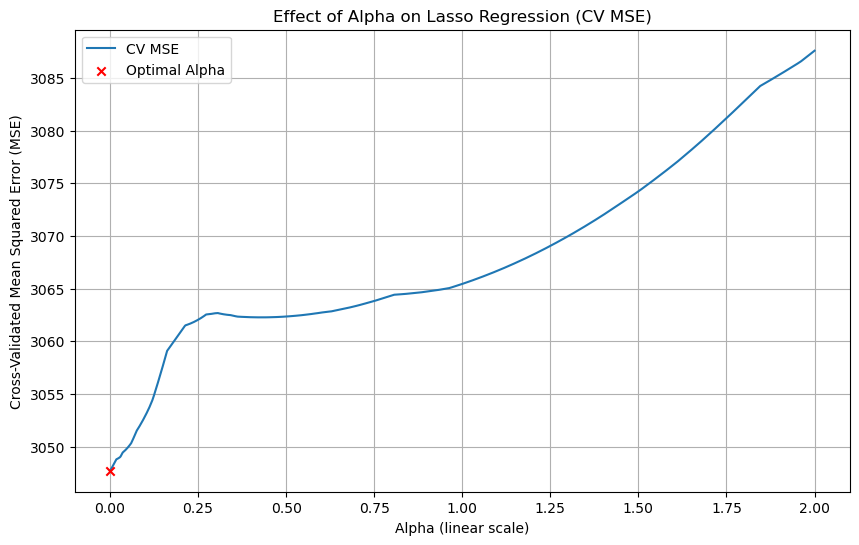

Optimal alpha: 1e-10
Optimal CV score (MSE): 3047.7321
Test MSE: 2743.9112

Intercept: 152.0101

Feature  Coefficient
    age       0.9303
 gender     -12.4590
    bmi      23.8992
     bp      16.1854
     s1     -40.0818
     s2      22.8955
     s3       5.7735
     s4      11.4424
     s5      34.1838
     s6       3.3935


In [17]:
run_lasso_regression(X_train,y_train,X_test,y_test,
                             log_alphas = np.logspace(-10, -3, 100),  # Logarithmic range from 1e-6 to 1e-3
                             lin_alphas = np.linspace(1e-10, 2, 1000),
                             max_iter   = 100000,
                             log_scale  = False
                            )

### Summary of Results for Diabetes Dataset

| CV Score   | Test      | Method               |
|------------|-----------|----------------------|
| 2944.8991  | 2703.7499 | Exhaustive Selection |
| 2944.8991  | 2703.7499 | Backward Selection   |
| 2947.8309  | 2711.9788 | Forward Selection    |
| 3047.6931  | 2743.1588 | Ridge Regression     |
| 3047.7321  | 2743.9112 | Lasso Regression     |
| 3047.7321  | 2743.9112 | Linear Regression    |


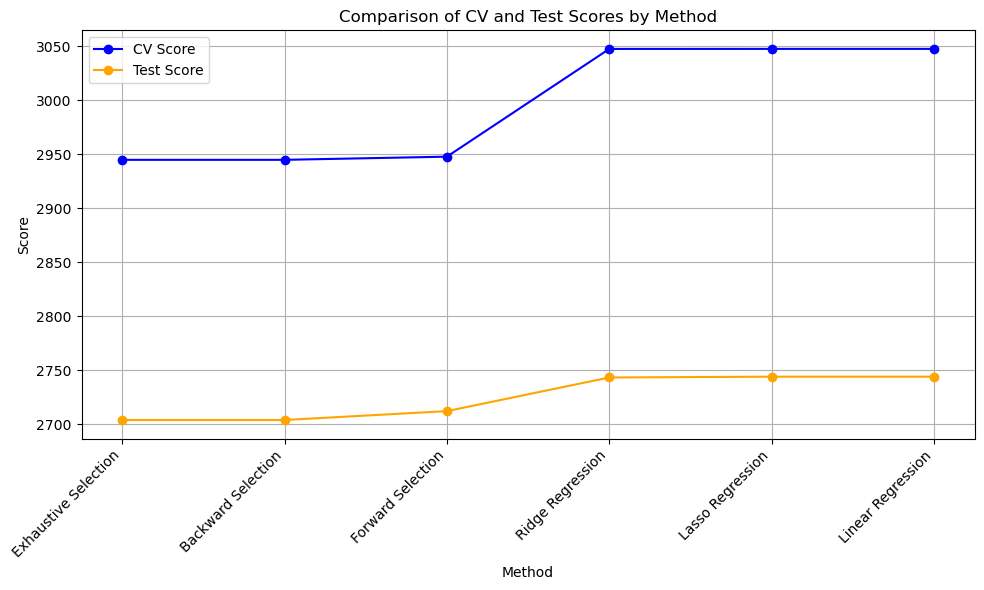

In [18]:
# Data preparation
data = {
    "Method": [
        "Exhaustive Selection", 
        "Backward Selection", 
        "Forward Selection", 
        "Ridge Regression", 
        "Lasso Regression", 
        "Linear Regression"
    ],
    "CV Score": [2944.8991, 2944.8991, 2947.8309, 3047.6931, 3047.7321, 3047.7321],
    "Test Score": [2703.7499, 2703.7499, 2711.9788, 2743.1588, 2743.9112, 2743.9112]
}

df_summary = pd.DataFrame(data)

# Plot configuration for line plot
plt.figure(figsize=(10, 6))

# Plot CV Scores
plt.plot(df_summary["Method"], df_summary["CV Score"], marker='o', label="CV Score", color="blue", linestyle='-')

# Plot Test Scores
plt.plot(df_summary["Method"], df_summary["Test Score"], marker='o', label="Test Score", color="orange", linestyle='-')

# Adding labels and formatting
plt.xticks(rotation=45, ha="right")
plt.xlabel("Method")
plt.ylabel("Score")
plt.title("Comparison of CV and Test Scores by Method")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### Once More: The Auto MPG Dataset for Ridge and Lasso Regression

Lasso Regression performs better when there are lots of features, many of which are irrelevant. This occurs, for example, in genomic datasets, where there are 1000s or even millions of features (one for each gene), but only a small number come into play at any moment. 

Let's try another dataset, which is small but has several low-information features. 

In [19]:
# Download the Auto MPG dataset
path = kagglehub.dataset_download("uciml/autompg-dataset")
# print("Path to dataset files:", path)

# Load the dataset (assuming the main CSV file is named `auto-mpg.csv`)
file_path = f"{path}/auto-mpg.csv"
df_mpg = pd.read_csv(file_path)
df_mpg

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [20]:
# Preprocessing the dataset to make it suitable for regression

# Replace '?' with NaN and convert columns to appropriate data types
df_mpg.replace('?', pd.NA, inplace=True)

# Convert columns with numeric data to the appropriate types (e.g., horsepower)
df_mpg['horsepower'] = pd.to_numeric(df_mpg['horsepower'], errors='coerce')

# Drop rows with missing values
df_mpg.dropna(inplace=True)

# Define features (X) and target (y)
X_mpg = df_mpg.drop(columns=["mpg", "car name"])  # Exclude the target and non-numeric columns
y_mpg = df_mpg["mpg"]

# Split the dataset into training and testing sets (20% test data)
X_train_mpg, X_test_mpg, y_train_mpg, y_test_mpg = train_test_split(X_mpg, y_mpg, test_size=0.2, random_state=42)

len(X_train_mpg),len(X_test_mpg), len(y_train_mpg), len(y_test_mpg) 

(313, 79, 313, 79)

In [21]:
# Run linear regression in Auto MPG dataset

# In order to compare the coefficients, we scale the parameters for linear regression, which
# is not necesssary for obtaining scores, but does affect the coefficients

# Scale the data
scaler = StandardScaler()
X_train_mpg_scaled = scaler.fit_transform(X_train_mpg)
X_test_mpg_scaled = scaler.transform(X_test_mpg)

cv_score, test_mse, baseline_model = run_linear_regression(X_train_mpg_scaled, y_train_mpg, 
                                                           X_test_mpg_scaled, y_test_mpg,
                                                           cv=5, 
                                                           scoring='neg_mean_squared_error'
                                                          )

# Print the results
print("Baseline Linear Regression:\n")
print(f"CV Score: {cv_score:.4f}")
print(f"Test MSE: {test_mse:.4f}\n")

# Extract coefficients
coefficients = baseline_model.coef_  # Coefficients for each feature
intercept = baseline_model.intercept_  # Intercept term


# Automatically extract feature names from X_train
feature_names = X_train_mpg.columns.tolist()

coefficients_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefficients
})

print(f"Intercept: {intercept:.4f}\n")

print(coefficients_df.to_string(index=False))



Baseline Linear Regression:

CV Score: 11.9075
Test MSE: 10.7109

Intercept: 23.5994

     Feature  Coefficient
   cylinders    -0.587055
displacement     1.565273
  horsepower    -0.814205
      weight    -5.157671
acceleration     0.106767
  model year     2.782555
      origin     1.300240


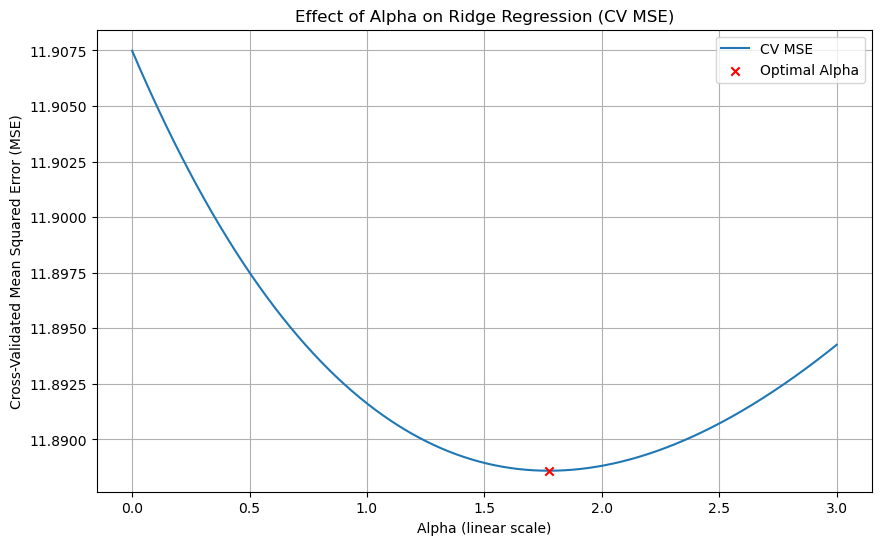

Optimal alpha: 1.7748
Optimal CV score (MSE): 11.8886
Test MSE: 10.8079

Intercept: 23.5994

     Feature  Coefficient
   cylinders      -0.5064
displacement       1.1972
  horsepower      -0.8705
      weight      -4.8602
acceleration       0.0448
  model year       2.7470
      origin       1.2804


In [22]:
run_ridge_regression(X_train_mpg,y_train_mpg,X_test_mpg,y_test_mpg,
                     log_alphas = np.logspace(-6, -3, 1000),  # Logarithmic range from 1e-6 to 1e-3
                     lin_alphas = np.linspace(0, 3, 1000),
                     log_scale=False
                    )

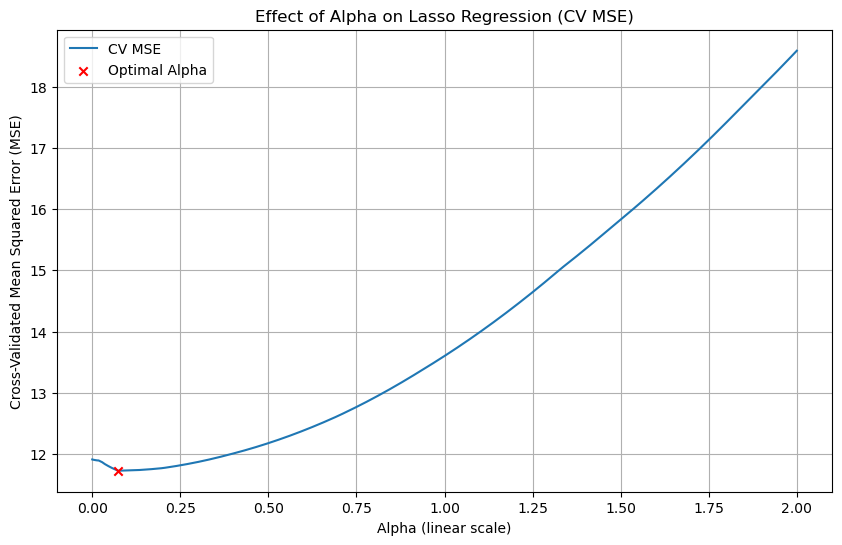

Optimal alpha: 0.07407503703703705
Optimal CV score (MSE): 11.7230
Test MSE: 10.9787

Intercept: 23.5994

     Feature  Coefficient
   cylinders      -0.0000
displacement       0.0000
  horsepower      -0.5288
      weight      -4.5921
acceleration       0.0000
  model year       2.6890
      origin       1.0957


In [23]:
coefs = run_lasso_regression(X_train_mpg,y_train_mpg,X_test_mpg,y_test_mpg,
                             log_alphas = np.logspace(-10, -3, 100),  # Logarithmic range from 1e-6 to 1e-3
                             lin_alphas = np.linspace(1e-6, 2, 1000),
                             max_iter   = 10000,
                             log_scale  = False
                            )


| CV Score   | Test      | Method               |
|------------|-----------|----------------------|
| 11.7230  | 10.9787 | Lasso Regression     |
| 11.8886  | 10.8079 | Ridge Regression     |
| 11.9075  | 10.7109 | Linear Regression    |

### How did Ridge and Lasso shrink the coefficients?


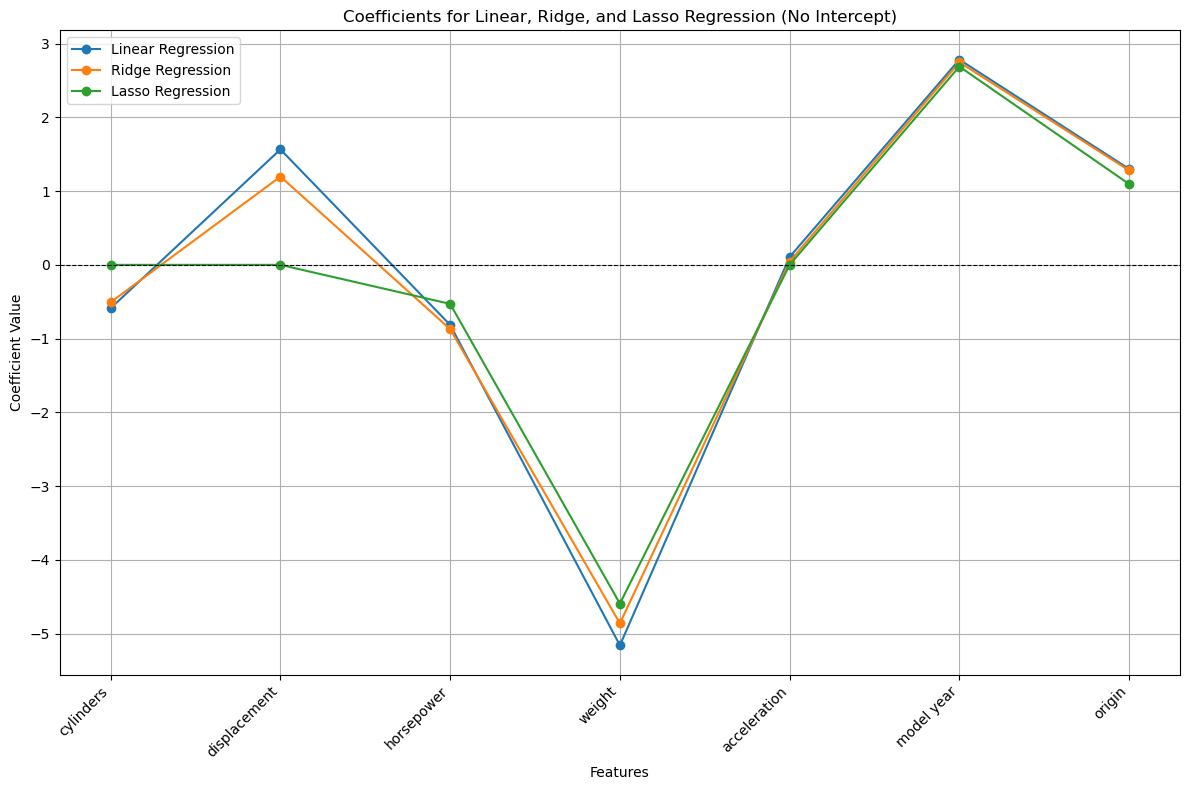

In [24]:
# Display coefficients for all three methods

# Updated data with new Linear Regression coefficients
data = {
    "Linear Regression": {
        "Coefficients": {
            "cylinders": -0.587055,
            "displacement": 1.565273,
            "horsepower": -0.814205,
            "weight": -5.157671,
            "acceleration": 0.106767,
            "model year": 2.782555,
            "origin": 1.300240,
        },
    },
    "Ridge Regression": {
        "Coefficients": {
            "cylinders": -0.506382,
            "displacement": 1.197198,
            "horsepower": -0.870539,
            "weight": -4.860170,
            "acceleration": 0.044776,
            "model year": 2.747013,
            "origin": 1.280361,
        },
    },
    "Lasso Regression": {
        "Coefficients": {
            "cylinders": -0.000000,
            "displacement": 0.000000,
            "horsepower": -0.528785,
            "weight": -4.592088,
            "acceleration": 0.000000,
            "model year": 2.689001,
            "origin": 1.095653,
        },
    },
}

# Prepare data for plotting
features = list(data["Linear Regression"]["Coefficients"].keys())
models = {
    model_name: list(details["Coefficients"].values())
    for model_name, details in data.items()
}

# Plot coefficients for each model
plt.figure(figsize=(12, 8))
for model_name, coefficients in models.items():
    plt.plot(features, coefficients, marker='o', label=model_name)

# Customize the plot
plt.xticks(rotation=45, ha='right')
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.title("Coefficients for Linear, Ridge, and Lasso Regression (No Intercept)")
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')
plt.legend()
plt.tight_layout()
plt.grid()
plt.show()


## Appendix: Statistical Tests for Variable Significance

Although we didn’t cover it in this week’s lesson, and feature selection and regularization techniques don’t directly rely on them, they play a crucial role in Exploratory Data Analysis (EDA). Understanding how features influence the target variable provides valuable insights and guides model development. I encourage you to explore this optional section, as it includes key concepts and practical template code to enhance your EDA process.

In Week 9, we will return to this topic, and will investigate how the significance of features can be manipulated inside the model, where we will call these "Variable Importance Measures."


### Exploring a Regression Dataset Using a Correlation Matrix

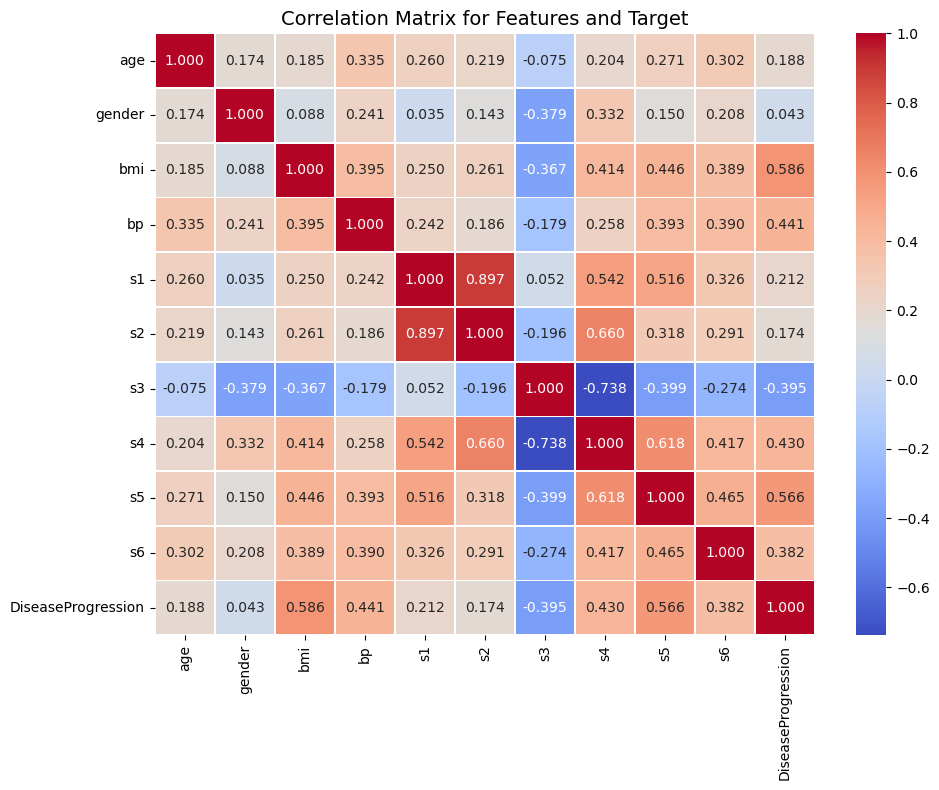

In [25]:
# Compute the correlation matrix for the Diabetes Dataset

correlation_matrix = df_diabetes.corr()           

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", cbar=True, fmt=".3f",
            linewidths=0.5, xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.index)

# Add a title
plt.title("Correlation Matrix for Features and Target", fontsize=14)
plt.tight_layout()
plt.show()


The correlation matrix provided by Pandas' `.corr()` function offers a quick and straightforward way to explore relationships between features and the target variable. While useful for initial exploratory analysis, correlation has significant limitations as a measure of feature importance:

- Correlation captures only linear relationships and may miss nonlinear dependencies that are critical in complex datasets.
- It is sensitive to noise and outliers, making it unreliable for robust feature selection.
- It does not account for interactions between features or their combined effect on the target variable, which can be crucial in predictive modeling.

Note: Whether the correlation is positive or negative does not matter, only the absolute value of the correlation, showing the amount of linear correlation between the individual feature and the target.

### F-Scores


Rather than use correlation, F-scores are more robust and informative for feature selection in regression because they account for variance and noise, and are accompanied by p-values, which are important in determining whether the observed relationship between a feature and the target is statistically significant.

$$F = \frac{\text{Variance explained by the feature}}{\text{Variance not explained by the feature}} = \frac{\text{Var}(\hat{y}_i)}{\text{Var}(y - \hat{y}_i)},$$

where $\hat{y}_i$ is the vector of predicted values for the target $y$ obtained using *only* feature $i$ in a univariate regression.

### p-Values
Furthermore, the `sklearn` library returns the **p-value** of a Hypothesis Test of the hypothesis "This feature makes no contribution to the target value."

Obviously, the smaller the p-value, the larger the statistical significance of the F-score; typically a threshold of $𝑝\le 0.05$ is used for a "statistically significant" contribution.

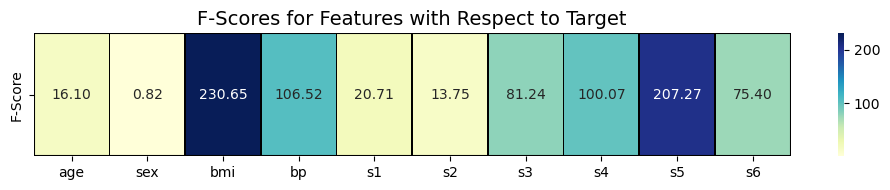

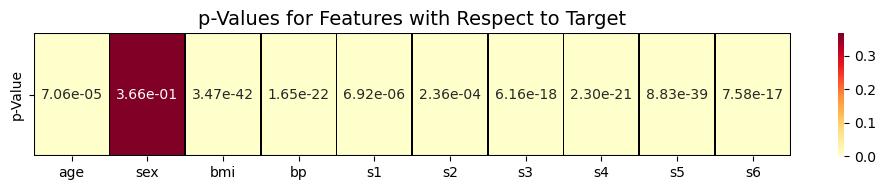

In [26]:
# Displaying F-Scores and p-values


# Scale the features and response for proper F-score; not necessary for calculating p-value.

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1)).flatten()             

# Compute F-scores and p-values using f_regression
f_scores, p_values = f_regression(X_scaled, y_scaled)

# Create DataFrames for F-scores and p-values
f_score_matrix = pd.DataFrame(f_scores.reshape(1, -1), columns=data_diabetes.feature_names, index=["F-Score"])
p_value_matrix = pd.DataFrame(p_values.reshape(1, -1), columns=data_diabetes.feature_names, index=["p-Value"])

# Plot the F-score heatmap
plt.figure(figsize=(10, 2))
ax = sns.heatmap(
    f_score_matrix,
    annot=True,
    cmap="YlGnBu",
    cbar=True,
    fmt=".2f",
    linewidths=0.5,  # Thickness of the cell edges
    linecolor="black",  # Black edges between cells
    xticklabels=f_score_matrix.columns,
    yticklabels=f_score_matrix.index
)

# Add a consistent black border around the entire heatmap
ax.add_patch(patches.Rectangle(
    (0, 0),  # Bottom-left corner
    f_score_matrix.shape[1],  # Width (number of columns)
    f_score_matrix.shape[0],  # Height (number of rows)
    edgecolor='black',  # Border color
    fill=False,  # Do not fill the rectangle
    lw=1.5  # Line width of the border
))

plt.title("F-Scores for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()


# Plot the p-value heatmap
plt.figure(figsize=(10, 2))
ax = sns.heatmap(
    p_value_matrix,
    annot=True,
    cmap="YlOrRd",
    cbar=True,
    fmt=".2e",
    linewidths=0.5,  # Thickness of the cell edges
    linecolor="black",  # Black edges between cells
    xticklabels=p_value_matrix.columns,
    yticklabels=p_value_matrix.index
)

# Add a consistent border around the entire heatmap
ax.add_patch(patches.Rectangle(
    (0, 0),  # Bottom-left corner
    p_value_matrix.shape[1],  # Width (number of columns)
    p_value_matrix.shape[0],  # Height (number of rows)
    edgecolor='black',  # Border color
    fill=False,  # Do not fill the rectangle
    lw=1.5  # Line width of the border
))

plt.title("p-Values for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()


Let's compare with the correlations. 

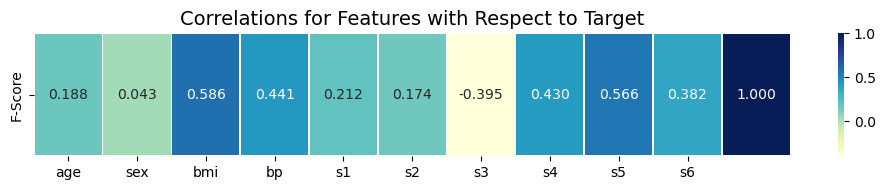

In [27]:
# correlation_matrix[['Target']]

# Plot the F-score heatmap
plt.figure(figsize=(10, 2))
sns.heatmap(correlation_matrix[-1:], annot=True, cmap="YlGnBu", cbar=True, fmt=".3f",
            linewidths=0.5, xticklabels=f_score_matrix.columns, yticklabels=f_score_matrix.index)
plt.title("Correlations for Features with Respect to Target", fontsize=14)
plt.tight_layout()
plt.show()

Interestingly, and possibly because this dataset is neither noisy nor complex, all three metrics agree on the relative importance of these features. Note that for correlation, the measure of interest is typically its absolute value (i.e., its magnitude), rather than its signed value. Meanwhile, the p-value indicates the probability of no relationship between the feature and the target variable, so smaller p-values suggest a stronger relationship.  



|  Feature     | Correlation | F-Score     | p-Value       |     
|--------------|-------------|-------------|---------------|
| **bmi**      | 0.586       | 230.65      | 3.47e-42      |
| **s5**       | 0.566       | 207.27      | 8.83e-39      |
| **bp**       | 0.441       | 106.52      | 1.65e-22      |
| **s4**       | 0.430       | 100.07      | 2.30e-21      |
| **s3**       | -0.395      | 81.24       | 6.16e-18      |
| **s6**       | 0.382       | 75.40       | 7.58e-17      |
| **s1**       | 0.212       | 20.71       | 6.92e-06      |
| **age**      | 0.188       | 16.10       | 7.06e-05      |
| **s2**       | 0.174       | 13.75       | 2.36e-04      |
| **gender**      | 0.043       | 0.82        | 3.66e-01      |

Notes:

- We show correlation just for comparison; it should **not** be used as a variable importance measure!


- It seems **gender** is the only feature not "statistically significant," since $.366\not\leq0.05$.  

Another useful visualization is to display the F-Scores as a ranked bar chart:

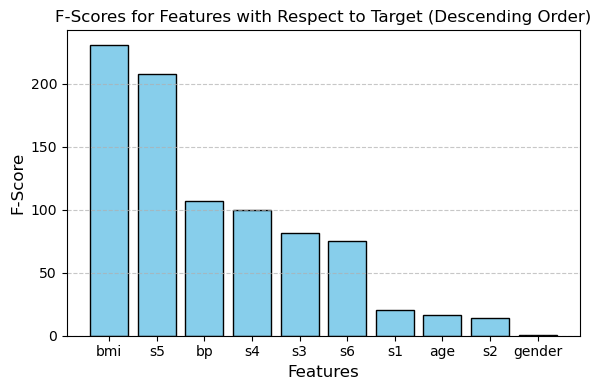

In [28]:
# Display bar chart with features sorted wrt F-Score

# Data
features = ['age', 'gender', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']
f_scores = [16.10, 0.82, 230.65, 106.52, 20.71, 13.75, 81.24, 100.07, 207.27, 75.40]

# Sort the data by F-Scores in descending order
sorted_indices = np.argsort(f_scores)[::-1]
features_sorted = [features[i] for i in sorted_indices]
f_scores_sorted = [f_scores[i] for i in sorted_indices]

# Create a vertical bar chart
plt.figure(figsize=(6, 4))
plt.bar(features_sorted, f_scores_sorted, color='skyblue', edgecolor='black')
plt.ylabel('F-Score', fontsize=12)
plt.xlabel('Features', fontsize=12)
plt.title('F-Scores for Features with Respect to Target (Descending Order)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Display the chart
plt.tight_layout()
plt.show()
